In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import GridSpec
import matplotlib.gridspec as gridspec
import glob
import pandas as pd
import math
import random
import scipy
from scipy.stats import mannwhitneyu

import seaborn as sns

plt.style.use('styleNB.mplstyle')

###############################
# directionality calculations
# https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
###############################
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) 



wt = 'dHL60KW'
ko = 'dHL60TMEM154KO'
res = 'dHL60TMEM154KO-clone1galvanin-GFP-HA'


# Figure 2 Related

## Load in data

In [2]:
f_compiled = '../../data/processed_3D_tracking/20240424_compiled_galvaninKOlines_tracking.csv'

df = pd.read_csv(f_compiled)
df = df[['cell', 'frame', 'x', 'y', 'z', 'celltype', 'E_V_cm',
       'date', 'trial', 'user']]
df = df[df.celltype != 'dHL60TMEM154KO-clone1galvanin-GFP-HA']

f_rescue_filtered = '../../data/processed_3D_tracking/20240424_compiled_galvaninKOlines_rescue_tracking_GFPplus.csv'
df_gfp = pd.read_csv(f_rescue_filtered)
df_gfp = df_gfp[['cell', 'frame', 'x', 'y', 'z',
       'celltype', 'E_V_cm', 'date', 'trial', 'user']]


df = pd.concat([df, df_gfp], ignore_index = True)

df = df.replace('dHL60TMEM154KO-clone1', 'dHL60TMEM154KO')
df = df.replace('dHL60TMEM154KO-clone12', 'dHL60TMEM154KO')

# remove cells at the periphery
df_temp_ = pd.DataFrame()
for g, d_ in df.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 10):
        continue
    
    # Append the row to the DataFrame using concat
    df_temp_ = pd.concat([df_temp_, d_], ignore_index=True)
    
df = df_temp_

df.celltype.unique()

array(['dHL60KW', 'dHL60TMEM154KO',
       'dHL60TMEM154KO-clone1galvanin-GFP-HA'], dtype=object)

In [3]:
celllines = df.celltype.unique() 
colors = sns.color_palette("tab10")
color_dict = dict(zip(df.celltype.unique(), colors))    
color_dict.update({'dHL60KW':'#B8BABC'})


In [4]:
df.head()

,cell,frame,x,y,z,celltype,E_V_cm,date,trial,user
0,2,0,120.978813,112.622173,95.220957,dHL60KW,0,20240211,1,NB
1,2,1,121.789041,110.832850,89.974652,dHL60KW,0,20240211,1,NB
2,2,2,119.305723,109.086509,86.228526,dHL60KW,0,20240211,1,NB
3,2,3,116.390924,110.453731,85.311001,dHL60KW,0,20240211,1,NB
4,2,4,112.674970,109.090071,85.778671,dHL60KW,0,20240211,1,NB


# Autocorrelation analysis and plots

In [8]:
###############################
# Autocorrelation calculation
###############################

def non_overlapping_normalized_autocorrelation(signal):
    """
    Calculate the non-overlapping normalized autocorrelation of a 1D signal.
    
    Parameters:
    signal (np.ndarray): Input 1D signal.
    
    Returns:
    np.ndarray: Non-overlapping normalized autocorrelation values.
    """
    n = len(signal)
    autocorrelation = np.zeros(n)
    
    for lag in range(n):
        sum_product = 0
        count = 0
        for i in range(0, n - lag, lag + 1):
            sum_product += signal[i] * signal[i + lag]
            count += 1
        
        if count > 0:
            # Normalizing with respect to the sum of squares for lag 0
            normalization_factor = np.sqrt(np.sum(signal[:n - lag:lag + 1] ** 2) * np.sum(signal[lag:n:lag + 1] ** 2))
            autocorrelation[lag] = sum_product / normalization_factor if normalization_factor != 0 else 0
    
    return autocorrelation
    
    
    
df_angle_E_3 = pd.DataFrame()

for g, d_ in df.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):

    if len(np.arange(d_.frame.min(), d_.frame.max())) + 1 != len(d_.frame.unique()):
        continue
    else:
        # Iterate over frames with a step size of 3
        for t in np.arange(d_.frame.min() + 3, d_.frame.max() + 1, 3):
            if (t - 3) < d_.frame.min():  # Ensure there's enough data for the intervals
                continue
            
            vec_t1 = [d_[d_.frame == t-3].x.values[0] - d_[d_.frame == t].x.values[0],
                      d_[d_.frame == t-3].y.values[0] - d_[d_.frame == t].y.values[0]]
            vec_t2 = [3, 0]  # reference vector (magnitude not important)

            datalist = {'celltype': g[0],
                        'E_V_cm': g[1],
                        'date': g[2],
                        'trial': g[3],
                        'user': g[4],
                        'cell': g[5],
                        'interval': t,
                        'angle': angle_between(vec_t2, vec_t1),
                        'cos_angle': np.cos(angle_between(vec_t2, vec_t1))}
            df_dict = pd.DataFrame([datalist])
            df_angle_E_3 = pd.concat([df_angle_E_3, df_dict], ignore_index=True)


/var/folders/hs/8f67z23n6g9g9g4y03yhrn_c0000gn/T/ipykernel_4921/650718491.py:26: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


In [9]:
df_angle_E_3.head()

,celltype,E_V_cm,date,trial,user,cell,interval,angle,cos_angle
0,dHL60KW,0,20240211,1,NB,2,3,0.441525,0.904101
1,dHL60KW,0,20240211,1,NB,2,6,0.113794,0.993532
2,dHL60KW,0,20240211,1,NB,2,9,0.323320,0.948186
3,dHL60KW,0,20240211,1,NB,2,12,2.789571,-0.938678
4,dHL60KW,0,20240211,1,NB,2,15,2.560548,-0.835889


In [10]:
for g, d in df_angle_E_3.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user']):
    if g[0] != 'dHL60TMEM154KO-clone1galvanin-GFP-HA': #'dHL60KW':
        continue
    if g[1] == 5:
        continue
    print(g)
    print(len(d.cell.unique()))



('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0, 20240229, 1, 'HK')
35
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0, 20240306, 1, 'HK')
56
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0, 20240307, 1, 'HK')
31
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0, 20240307, 2, 'HK')
88
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0, 20240313, 1, 'HK')
200
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0, 20240320, 1, 'HK')
75
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0, 20240320, 1, 'TE')
114
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0, 20240328, 1, 'HK')
98
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0, 20240403, 1, 'HK')
100
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 1, 20240306, 1, 'HK')
102
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 1, 20240306, 2, 'HK')
124
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 1, 20240320, 1, 'HK')
81
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 1, 20240320, 1, 'TE')
80
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 1, 20240327, 1, 'TE')
122
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 1, 20240328, 1, 'HK')
87
('dH

('dHL60KW', 0)
(571,)
('dHL60KW', 1)
(738,)
('dHL60KW', 3)
(501,)
('dHL60TMEM154KO', 0)
(959,)
('dHL60TMEM154KO', 1)
(1063,)
('dHL60TMEM154KO', 3)
(934,)
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0)
(750,)
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 1)
(652,)
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 3)
(430,)


Text(0, 0.5, 'compass autocorrelation of cos$\\theta$')

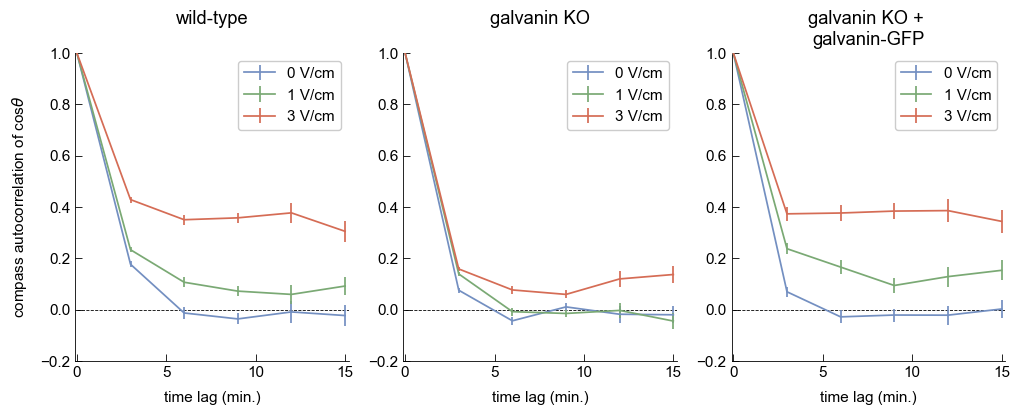

In [11]:
f, ax = plt.subplots(1,3, figsize = (12,4))

for g, d in df_angle_E_3.groupby(['celltype', 'E_V_cm']):
    if g[0] != 'dHL60KW':
        continue
    if g[1] == 5:
        continue
    
    acf_all = np.zeros(8)
    
    for g_, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
        d_ = d_.sort_values('interval')
        y = d_.cos_angle.values

        # need each array to be same length (take only full length 
        # tracks, or ones missing an interval)
        if len(y) > 8:
            y = y[:8]
        if len(y) != 8:
            continue

        acf = non_overlapping_normalized_autocorrelation(y)  

        acf_all = np.vstack([acf_all, acf])

        
    acf_all = acf_all[1:,:]
    print(g)
    print(np.mean(acf_all, axis =1).shape)
    ax[0].errorbar(x = np.arange(6)*3,
                   y = np.mean(acf_all[:,:6], axis =0), 
                   yerr = np.var(acf_all[:,:6], axis =0)/np.sqrt(len(acf_all[:,:6])),
                   label = ''.join([str(g[1]),' V/cm']), zorder = 10, lw = 1.25)
    
ax[0].legend()
ax[0].set_title('wild-type\n')


for g, d in df_angle_E_3.groupby(['celltype', 'E_V_cm']):
    if g[0] != 'dHL60TMEM154KO':
        continue
    if g[1] == 5:
        continue
        
    acf_all = np.zeros(8)
    
    for g_, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
        d_ = d_.sort_values('interval')
        y = d_.cos_angle.values

        # need each array to be same length (take only full length 
        # tracks, or missing one interval)
        if len(y) > 8:
            y = y[:8]
        if len(y) != 8:
            continue

        acf = non_overlapping_normalized_autocorrelation(y)  

        acf_all = np.vstack([acf_all, acf])

        
    acf_all = acf_all[1:,:]
    print(g)
    print(np.mean(acf_all, axis =1).shape)
    ax[1].errorbar(x = np.arange(6)*3,
                   y = np.mean(acf_all[:,:6], axis =0), 
                   yerr = np.var(acf_all[:,:6], axis =0)/np.sqrt(len(acf_all[:,:6])),
                   label = ''.join([str(g[1]),' V/cm']), zorder = 10, lw = 1.25)
    
ax[1].legend()
ax[1].set_title('galvanin KO\n')


for g, d in df_angle_E_3.groupby(['celltype', 'E_V_cm']):
    if g[0] != 'dHL60TMEM154KO-clone1galvanin-GFP-HA':
        continue
    if g[1] == 5:
        continue
        
    acf_all = np.zeros(8)
    
    for g_, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
        d_ = d_.sort_values('interval')
        y = d_.cos_angle.values
        
        # need each array to be same length (take only full length 
        # tracks, or ones missing an interval)
        if len(y) > 8:
            y = y[:8]
        if len(y) != 8:
            continue

        acf = non_overlapping_normalized_autocorrelation(y) 

        acf_all = np.vstack([acf_all, acf])

        
    acf_all = acf_all[1:,:]
    print(g)
    print(np.mean(acf_all, axis =1).shape)
    ax[2].errorbar(x = np.arange(6)*3,
                   y = np.mean(acf_all[:,:6], axis =0), 
                   yerr = np.std(acf_all[:,:6], axis =0)/np.sqrt(len(acf_all[:,:6])),
                   label = ''.join([str(g[1]),' V/cm']), zorder = 10, lw = 1.25)
    
ax[2].legend()
ax[2].set_title('galvanin KO + \ngalvanin-GFP')

for ax_ in ax:
    ax_.set_xlim(-0.1, 5*3+0.2)
    ax_.set_ylim(-0.2, 1)
    ax_.hlines(0,0,6*3, zorder = 0, color = 'k', linestyle = '--')
    ax_.set_xlabel('time lag (min.)')
ax[0].set_ylabel('compass autocorrelation '
                 r'of cos$\theta$')

# plt.savefig('../../figures/Figure3_supp_autocorr.pdf')

dHL60KW
dHL60TMEM154KO
dHL60TMEM154KO-clone1galvanin-GFP-HA


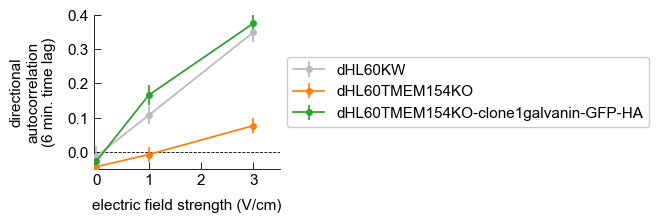

In [15]:
df_acf = pd.DataFrame()

for g, d in df_angle_E_3.groupby(['celltype', 'E_V_cm']):
    
    acf_all = np.zeros(8)
    for g_, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
        d_ = d_.sort_values('interval')
        y = d_.cos_angle.values
        if len(y) > 8:
            y = y[:8]
        if len(y) != 8:
            continue

        acf = [1] #initializing list with autocorrelation coefficient for lag k=0 which is always 1
        acf = non_overlapping_normalized_autocorrelation(y) #calling autocorr function for each lag 'i'

        acf_all = np.vstack([acf_all, acf])

    data_list = {'celltype': g[0],
                 'E_V_cm' : g[1],
                'autocorr_0' : acf_all[:,0],
                'autocorr_1' : acf_all[:,1],
                'autocorr_2' : acf_all[:,2],
                'autocorr_3' : acf_all[:,3],
                'autocorr_4' : acf_all[:,4],
                'autocorr_5' : acf_all[:,5]}
    
    df_dict = pd.DataFrame([data_list])
    df_acf = pd.concat([df_acf, df_dict], ignore_index=True)
    


f, ax = plt.subplots(1,1, figsize = (3,2))

for g, d in df_acf.groupby('celltype'):
    print(g)
    ax.errorbar(x = d.E_V_cm.values[:-1],
                   y = [np.mean(x) for x in d.autocorr_2.values][:-1], 
                   yerr = [np.std(x)/np.sqrt(len(x)) for x in d.autocorr_2.values][:-1],
                   label = g, 
                  zorder = 10, lw = 1.25, marker = 'o', markersize = 4,
                color = color_dict[g])

    
plt.xlim(-0.05,3.5)
plt.ylim(-0.05,0.4)

plt.legend()


ax.hlines(0,0,6, zorder = 0, color = 'k', linestyle = '--')

ax.set_xlabel('electric field strength (V/cm)')
ax.set_ylabel('directional\nautocorrelation\n(6 min. time lag)')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('../../figures/Figure3_autocorrelation_.pdf')


# Histogram plots of speed along electric field direction

In [6]:
# I want plots with equally spaced bins across all the cell lines. I need to determine the data range first.; otherwise this can be ignored.

count = 0
for E, df_temp in df.groupby('E_V_cm'):
    if E == 5:
        continue
    if E == 1:
        continue
        
    count_int_kw = 0
    count_cell_kw = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60KW'].groupby(['celltype',  'E_V_cm'],  sort=False):
        dot_kw = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_kw += 1
                    
                dot_kw = np.append(dot_kw,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                
            count_cell_kw += 1
    
    count_int_ko = 0
    count_cell_ko = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO'].groupby(['celltype',  'E_V_cm'],  sort=False):
        dot_ko = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko += 1
                    
                dot_ko = np.append(dot_ko,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                
            count_cell_ko += 1
            
    count_int_res = 0
    count_cell_res = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone1galvanin-GFP-HA'].groupby(['celltype',  'E_V_cm'],  sort=False):
        dot_res = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_res += 1
                    
                dot_res = np.append(dot_res,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))

            count_cell_res += 1

    
    count += 1



0
('dHL60KW', 0)
wild-type
num. cells:  679
num. intervals:  5694
('dHL60TMEM154KO', 0)
knockout
num. cells:  1113
num. intervals:  9393
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0)
rescue
num. cells:  797
num. intervals:  6987
1
3
('dHL60KW', 3)
wild-type
num. cells:  601
num. intervals:  5032
('dHL60TMEM154KO', 3)
knockout
num. cells:  1052
num. intervals:  8985
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 3)
rescue
num. cells:  482
num. intervals:  4116
5


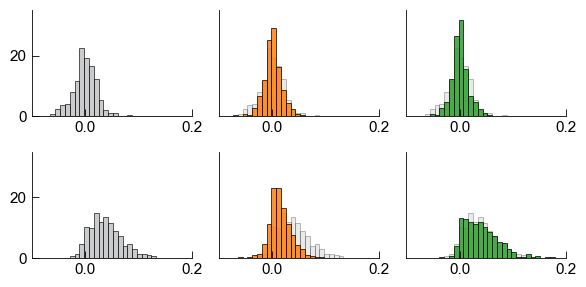

In [5]:
########################
# generate histograms with equal-sized bins
########################

# Determine the fixed bin width
bin_width = 0.009#6  # Adjust this value to your desired bin width

# Determine the common range for all histograms
data_min = min(np.min(dot_kw/(3.0*60)), np.min(dot_ko/(3.0*60)),  np.min(dot_res/(3.0*60)))  
data_max = max(np.max(dot_kw/(3.0*60)), np.max(dot_ko/(3.0*60)),  np.max(dot_res/(3.0*60)))

# Create bin edges based on the fixed bin width
bins = np.arange(data_min, data_max + bin_width, bin_width)

########################
# plots
########################

fig, axs = plt.subplots(nrows=2, ncols = 3, figsize = (6, 3))

count = 0
for E, df_temp in df.groupby('E_V_cm'):
    print(E)
    if E == 5:
        continue
    if E == 1:
        continue
        
    count_int_kw = 0
    count_cell_kw = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60KW'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_kw = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_kw += 1
                    
                dot_kw = np.append(dot_kw,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                
            count_cell_kw += 1
    print('wild-type')
    print('num. cells: ', count_cell_kw)
    print('num. intervals: ', count_int_kw)
    
    count_int_ko = 0
    count_cell_ko = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_ko = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko += 1
                    
                dot_ko = np.append(dot_ko,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                
            count_cell_ko += 1
            
    print('knockout')
    print('num. cells: ', count_cell_ko)
    print('num. intervals: ', count_int_ko)
    count_int_res = 0
    count_cell_res = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone1galvanin-GFP-HA'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)
        
        dot_res = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_res += 1
                    
                dot_res = np.append(dot_res,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))

            count_cell_res += 1
    print('rescue')
    print('num. cells: ', count_cell_res)
    print('num. intervals: ', count_int_res)              
            
    if count == 0:

        axs[count, 0].hist(dot_kw/(3.0*60), bins, density=True, 
                       alpha=0.75, color = color_dict[wt], linewidth=0.6,edgecolor='black',  label = 'wild-type')
        
        axs[count, 1].hist(dot_kw/(3.0*60), bins, density=True, 
                       alpha=0.3, color = color_dict[wt], linewidth=0.6,edgecolor='black',  label = 'wild-type')

        axs[count, 2].hist(dot_kw/(3.0*60), bins, density=True, 
                       alpha=0.3, color = color_dict[wt], linewidth=0.6,edgecolor='black',  label = 'wild-type')

        axs[count, 1].hist(dot_ko/(3.0*60), bins, density=True, 
                       alpha=0.85, color = color_dict[ko], linewidth=0.6, edgecolor='black', label = 'galvanin\nknockout')

        axs[count, 2].hist(dot_res/(3.0*60), bins, density=True, 
                       alpha=0.85, color = color_dict[res], linewidth=0.6, edgecolor='black', label = 'rescue\n(galvanin-GFP)')
    else:
        axs[count, 0].hist(dot_kw/(3.0*60), bins, density=True, 
                   alpha=0.75, color = color_dict[wt],edgecolor='black',  linewidth=0.6)
        
        axs[count, 1].hist(dot_kw/(3.0*60), bins, density=True, 
                   alpha=0.3, color = color_dict[wt],edgecolor='black',  linewidth=0.6)

        axs[count, 2].hist(dot_kw/(3.0*60), bins, density=True, 
                   alpha=0.3, color = color_dict[wt],edgecolor='black',  linewidth=0.6)

        axs[count, 1].hist(dot_ko/(3.0*60), bins, density=True, 
                       alpha=0.85, color = color_dict[ko],edgecolor='black',  linewidth=0.6)

        axs[count, 2].hist(dot_res/(3.0*60), bins, density=True, 
                       alpha=0.85, color = color_dict[res],edgecolor='black',  linewidth=0.6)
    
#     axs[count,1].set_title(str(E) + ' V/cm')
#     axs[count,0].set_ylabel('probability')
    count += 1


# axs[0, 0].set_title('\nwild-type')
# axs[0, 1].set_title('\ngalvanin knockout')
# axs[0, 2].set_title('galvanin knockout +\ngalvanin-GFP')

# axs[2, 0].set_xlabel(r'directed speed [$\mu$m/min]')
# axs[2, 1].set_xlabel(r'directed speed [$\mu$m/min]')
# axs[2, 2].set_xlabel(r'directed speed [$\mu$m/min]')


axs = axs.ravel()
for ax_ in axs:
    ax_.set_xlim(-0.1,0.2)
    ax_.set_ylim(0,35)
    ax_.set_yticks([0,20])

    
for ax_ind in [1,2,4,5]:
    axs[ax_ind].yaxis.set_visible(False)
        
plt.tight_layout()

# plt.savefig('../../figures/Figure3_projected_speeds_.pdf')

### Statistics to compare the mean values

In [10]:
print('0 mV/mm electric field condition')

count = 0
for E, df_temp in df.groupby('E_V_cm'):
    if E != 0:
        continue
         
    count_int_kw = 0
    count_cell_kw = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60KW'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_kw = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_kw += 1
                dot_kw = np.append(dot_kw,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_kw += 1
    print('wild-type')
    print('num. cells: ', count_cell_kw)
    print('num. intervals: ', count_int_kw)
    
    count_int_ko = 0
    count_cell_ko = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_ko = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko += 1
                dot_ko = np.append(dot_ko,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_ko += 1
            
    print('knockout')
    print('num. cells: ', count_cell_ko)
    print('num. intervals: ', count_int_ko)
    count_int_res = 0
    count_cell_res = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone1galvanin-GFP-HA'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)
        
        dot_res = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_res += 1
                dot_res = np.append(dot_res,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))

            count_cell_res += 1
    print('rescue')
    print('num. cells: ', count_cell_res)
    print('num. intervals: ', count_int_res)    

print(' ')

df_treat = dot_res
df_control = dot_kw
print('res_wt', mannwhitneyu(df_treat, df_control))   

df_treat = dot_ko
df_control = dot_kw
print('ko_wt', mannwhitneyu(df_treat, df_control))   

############################################
############################################
############################################

print('300 mV/mm electric field condition')

count = 0
for E, df_temp in df.groupby('E_V_cm'):
    if E != 3:
        continue
         
    count_int_kw = 0
    count_cell_kw = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60KW'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_kw = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_kw += 1
                dot_kw = np.append(dot_kw,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_kw += 1
    print('wild-type')
    print('num. cells: ', count_cell_kw)
    print('num. intervals: ', count_int_kw)
    
    count_int_ko = 0
    count_cell_ko = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_ko = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko += 1
                dot_ko = np.append(dot_ko,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_ko += 1
            
    print('knockout')
    print('num. cells: ', count_cell_ko)
    print('num. intervals: ', count_int_ko)
    count_int_res = 0
    count_cell_res = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone1galvanin-GFP-HA'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)
        
        dot_res = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_res += 1
                dot_res = np.append(dot_res,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))

            count_cell_res += 1
    print('rescue')
    print('num. cells: ', count_cell_res)
    print('num. intervals: ', count_int_res)     

print(' ')

df_treat = dot_res
df_control = dot_kw
print('res_wt', mannwhitneyu(df_treat, df_control))   

df_treat = dot_ko
df_control = dot_kw
print('ko_wt', mannwhitneyu(df_treat, df_control))  

0 mV/mm electric field condition
('dHL60KW', 0)
wild-type
num. cells:  679
num. intervals:  5694
('dHL60TMEM154KO', 0)
knockout
num. cells:  1113
num. intervals:  9393
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 0)
rescue
num. cells:  797
num. intervals:  6987
 
res_wt MannwhitneyuResult(statistic=279288.0, pvalue=0.2860932420987067)
ko_wt MannwhitneyuResult(statistic=391096.0, pvalue=0.21305361795148614)
300 mV/mm electric field condition
('dHL60KW', 3)
wild-type
num. cells:  601
num. intervals:  5032
('dHL60TMEM154KO', 3)
knockout
num. cells:  1052
num. intervals:  8985
('dHL60TMEM154KO-clone1galvanin-GFP-HA', 3)
rescue
num. cells:  482
num. intervals:  4116
 
res_wt MannwhitneyuResult(statistic=146048.0, pvalue=0.8135462560597002)
ko_wt MannwhitneyuResult(statistic=165792.0, pvalue=2.3916559429765507e-58)


# Plots to illustrate 3D tracks

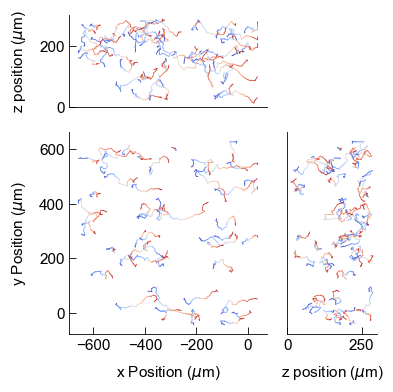

In [21]:
# 20240211_dHL60KW_3Vcm_1_user_NB_abs_trajectories.pdf
df_temp = df[df.celltype == 'dHL60KW']
df_temp = df_temp[df_temp.date == 20240211]
df_temp = df_temp[df_temp.user == 'NB']
df_temp = df_temp[df_temp.E_V_cm == 3]
df_temp = df_temp[df_temp.trial == 1]

df_temp_ = pd.DataFrame()
for g, d_ in df_temp.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 10):
        continue
    
    # Append the row to the DataFrame using concat
    df_temp_ = pd.concat([df_temp_, d_], ignore_index=True)
    
df_temp_.head()

ip = 0.642 # ip = 200.0/303.0
d = df_temp_
num_cells = len(d.cell.unique())

random_50_numbers = random.sample(d.cell.unique().tolist() , 50)


fig = plt.figure(figsize=(4,4))

gs = gridspec.GridSpec(2, 2,height_ratios=[1,(1024.0*ip)/300], width_ratios=[(1024.0*ip)/300,1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# Create a colormap
cmap = plt.get_cmap('coolwarm')  # A colormap that goes from blue to red
        
for c, d_  in d.groupby('cell'):
    if c not in random_50_numbers:
        continue
    
    if len(d_) <= 15:
        continue

    x = d_.x - 1024.0*ip
    y = 1024.0*ip - d_.y
    z = d_.z
    time = np.arange(len(x))
    
    # Normalize the time array to range from 0 to 1
    norm_time = (time - np.min(time)) / (np.max(time) - np.min(time))
    
    for i in range(len(x) - 1):
        ax1.plot(x[i:i+2], z[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
#     ax1.set_ylim(0,300)
#     ax1.set_xlim(-676,0)  
    ax1.set_ylabel('z position ($\mu$m)')
    
    # Plot the trajectory on the first subplot
    for i in range(len(x) - 1):
        ax2.plot(x[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax2.set_xlabel('x Position ($\mu$m)')
    ax2.set_ylabel('y Position ($\mu$m)')
#     ax2.set_xlim(0,-676)
#     ax2.set_ylim(0,676)  
    
    for i in range(len(x) - 1):
        ax3.plot(z[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax3.set_xlabel('z position ($\mu$m)')
#     ax3.set_xlim(0,300)
#     ax3.set_ylim(0,676)
        

    ax1.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)


plt.tight_layout()

# plt.savefig('../../figures/Figure3_tracks_WT.pdf')


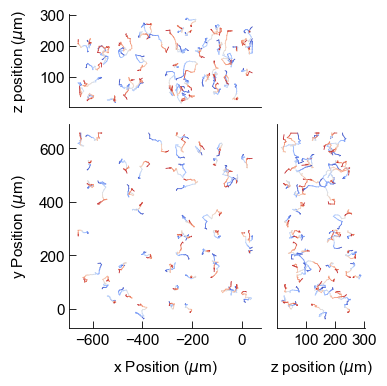

In [20]:
# 20240320_dHL60TMEM154KO-clone1_3Vcm_1_user_TE_abs_trajectories.pdf
df_temp = df[df.celltype == 'dHL60TMEM154KO']
df_temp = df_temp[df_temp.date == 20240320]
df_temp = df_temp[df_temp.user == 'TE']
df_temp = df_temp[df_temp.E_V_cm == 3]
df_temp = df_temp[df_temp.trial == 1]


df_temp_ = pd.DataFrame()
for g, d_ in df_temp.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 10):
        continue
    
    # Append the row to the DataFrame using concat
    df_temp_ = pd.concat([df_temp_, d_], ignore_index=True)
    
df_temp_.head()



ip = 0.642 # ip = 200.0/303.0
d = df_temp_
num_cells = len(d.cell.unique())

random_50_numbers = random.sample(d.cell.unique().tolist() , 50)


fig = plt.figure(figsize=(4,4))

gs = gridspec.GridSpec(2, 2,height_ratios=[1,(1024.0*ip)/300], width_ratios=[(1024.0*ip)/300,1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# Create a colormap
cmap = plt.get_cmap('coolwarm')  # A colormap that goes from blue to red


for c, d_  in d.groupby('cell'):
    if c not in random_50_numbers:
        continue
    
    if len(d_) <= 15:
        continue

    x = d_.x - 1024.0*ip
    y = 1024.0*ip - d_.y
    z = d_.z
    time = np.arange(len(x))
    
    # Normalize the time array to range from 0 to 1
    norm_time = (time - np.min(time)) / (np.max(time) - np.min(time))
    
    for i in range(len(x) - 1):
        ax1.plot(x[i:i+2], z[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
#     ax1.set_ylim(0,300)
#     ax1.set_xlim(-676,0)  
    ax1.set_ylabel('z position ($\mu$m)')
    
    # Plot the trajectory on the first subplot
    for i in range(len(x) - 1):
        ax2.plot(x[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax2.set_xlabel('x Position ($\mu$m)')
    ax2.set_ylabel('y Position ($\mu$m)')
#     ax2.set_xlim(0,-676)
#     ax2.set_ylim(0,676)  
    
    for i in range(len(x) - 1):
        ax3.plot(z[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax3.set_xlabel('z position ($\mu$m)')
#     ax3.set_xlim(0,300)
#     ax3.set_ylim(0,676)
        

    ax1.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)


plt.tight_layout()


# Add a colorbar to the first subplot
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
# sm.set_array([])
# fig.colorbar(sm, ax=ax2, orientation='vertical', label='Time')

# plt.savefig('../../figures/Figure3_tracks_KO.pdf')

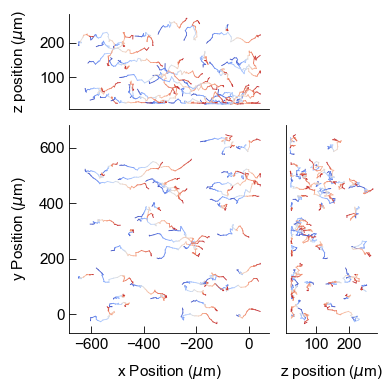

In [22]:
# 20240313_dHL60TMEM154KO-clone1galvanin-GFP-HA_3Vcm_1_user_HK_abs_trajectories.pdf
df_temp = df[df.celltype == 'dHL60TMEM154KO-clone1galvanin-GFP-HA']
df_temp = df_temp[df_temp.date == 20240313]
df_temp = df_temp[df_temp.user == 'HK']
df_temp = df_temp[df_temp.E_V_cm == 3]
df_temp = df_temp[df_temp.trial == 1]


df_temp_ = pd.DataFrame()
for g, d_ in df_temp.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 10):
        continue
    
    # Append the row to the DataFrame using concat
    df_temp_ = pd.concat([df_temp_, d_], ignore_index=True)
    

ip = 0.642 # ip = 200.0/303.0
d = df_temp_
num_cells = len(d.cell.unique())

random_50_numbers = random.sample(d.cell.unique().tolist() , 50)


fig = plt.figure(figsize=(4,4))

gs = gridspec.GridSpec(2, 2,height_ratios=[1,(1024.0*ip)/300], width_ratios=[(1024.0*ip)/300,1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# Create a colormap
cmap = plt.get_cmap('coolwarm')  # A colormap that goes from blue to red


for c, d_  in d.groupby('cell'):
    if c not in random_50_numbers:
        continue
    
    if len(d_) <= 15:
        continue

    x = d_.x - 1024.0*ip
    y = 1024.0*ip - d_.y
    z = d_.z
    time = np.arange(len(x))
    
    # Normalize the time array to range from 0 to 1
    norm_time = (time - np.min(time)) / (np.max(time) - np.min(time))
    
    for i in range(len(x) - 1):
        ax1.plot(x[i:i+2], z[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
#     ax1.set_ylim(0,300)
#     ax1.set_xlim(-676,0)  
    ax1.set_ylabel('z position ($\mu$m)')
    
    # Plot the trajectory on the first subplot
    for i in range(len(x) - 1):
        ax2.plot(x[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax2.set_xlabel('x Position ($\mu$m)')
    ax2.set_ylabel('y Position ($\mu$m)')
#     ax2.set_xlim(0,-676)
#     ax2.set_ylim(0,676)  
    
    for i in range(len(x) - 1):
        ax3.plot(z[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax3.set_xlabel('z position ($\mu$m)')
#     ax3.set_xlim(0,300)
#     ax3.set_ylim(0,676)
        

    ax1.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)


plt.tight_layout()


# Add a colorbar to the first subplot
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
# sm.set_array([])
# fig.colorbar(sm, ax=ax2, orientation='vertical', label='Time')

# plt.savefig('../../figures/Figure3_tracks_rescue.pdf')


In [ ]:
fig = plt.figure(figsize=(8,4))

gs = gridspec.GridSpec(2, 3,height_ratios=[1,(1024.0*ip)/300])

###########################
###########################
# a
###########################
###########################
ax_wt_xz = plt.subplot(gs[0])
ax_wt_xy = plt.subplot(gs[3])


# 20240211_dHL60KW_3Vcm_1_user_NB_abs_trajectories.pdf
df_temp = df[df.celltype == 'dHL60KW']
df_temp = df_temp[df_temp.date == 20240211]
df_temp = df_temp[df_temp.user == 'NB']
df_temp = df_temp[df_temp.E_V_cm == 3]
df_temp = df_temp[df_temp.trial == 1]

df_temp_ = pd.DataFrame()
for g, d_ in df_temp.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 10):
        continue
    
    # Append the row to the DataFrame using concat
    df_temp_ = pd.concat([df_temp_, d_], ignore_index=True)
    
df_temp_.head()

ip = 0.642 # ip = 200.0/303.0
d = df_temp_
num_cells = len(d.cell.unique())

random_50_numbers = random.sample(d.cell.unique().tolist() , 50)

# Create a colormap
cmap = plt.get_cmap('coolwarm')  # A colormap that goes from blue to red
   
for c, d_  in d.groupby('cell'):
    if c not in random_50_numbers:
        continue
    
    if len(d_) <= 15:
        continue

    x = d_.x 
    y = d_.y
    z = d_.z
    time = np.arange(len(x))
    
    # Normalize the time array to range from 0 to 1
    norm_time = (time - np.min(time)) / (np.max(time) - np.min(time))
    
    for i in range(len(x) - 1):
        ax_wt_xz.plot(x[i:i+2], z[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax_wt_xz.set_ylim(0,300)
    ax_wt_xz.set_xlim(0,700)  
    ax_wt_xz.set_ylabel('z position ($\mu$m)')
    
    # Plot the trajectory on the first subplot
    for i in range(len(x) - 1):
        ax_wt_xy.plot(x[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax_wt_xy.set_xlabel('x position ($\mu$m)')
    ax_wt_xy.set_ylabel('y position ($\mu$m)')
    ax_wt_xy.set_xlim(0,700)
    ax_wt_xy.set_ylim(0,700)  
    

    ax_wt_xz.xaxis.set_visible(False)
    

#############################
###########################
# b
###########################
###########################

ax_ko_xz = plt.subplot(gs[1])
ax_ko_xy = plt.subplot(gs[4])


df_temp = df[df.celltype == 'dHL60TMEM154KO']
df_temp = df_temp[df_temp.date == 20240320]
# df_temp = df_temp[df_temp.date == 20240229]
df_temp = df_temp[df_temp.user == 'TE']
df_temp = df_temp[df_temp.E_V_cm == 3]
df_temp = df_temp[df_temp.trial == 1]


df_temp_ = pd.DataFrame()
for g, d_ in df_temp.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 10):
        continue
    
    # Append the row to the DataFrame using concat
    df_temp_ = pd.concat([df_temp_, d_], ignore_index=True)


ip = 0.642 # ip = 200.0/303.0
d = df_temp_
num_cells = len(d.cell.unique())

random_50_numbers = random.sample(d.cell.unique().tolist() , 50)

# Create a colormap
cmap = plt.get_cmap('coolwarm')  # A colormap that goes from blue to red

for c, d_  in d.groupby('cell'):
    if c not in random_50_numbers:
        continue
    
    if len(d_) <= 15:
        continue

    x = d_.x
    y = d_.y
    z = d_.z
    time = np.arange(len(x))
    
    # Normalize the time array to range from 0 to 1
    norm_time = (time - np.min(time)) / (np.max(time) - np.min(time))
    
    for i in range(len(x) - 1):
        ax_ko_xz.plot(x[i:i+2], z[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax_ko_xz.set_ylim(0,300)
    ax_ko_xz.set_xlim(0,700) 
    ax_ko_xz.set_ylabel('z position ($\mu$m)')
    
    # Plot the trajectory on the first subplot
    for i in range(len(x) - 1):
        ax_ko_xy.plot(x[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax_ko_xy.set_xlabel('x position ($\mu$m)')
    ax_ko_xy.set_ylabel('y position ($\mu$m)')
    ax_ko_xy.set_xlim(0,700)
    ax_ko_xy.set_ylim(0,700)  
    
    ax_ko_xz.xaxis.set_visible(False)

    
###########################
###########################
# c
###########################
###########################
ax_res_xz = plt.subplot(gs[2])
ax_res_xy = plt.subplot(gs[5])

df_temp = df[df.celltype == 'dHL60TMEM154KO-clone1galvanin-GFP-HA']
df_temp = df_temp[df_temp.date == 20240313]
df_temp = df_temp[df_temp.user == 'HK']
df_temp = df_temp[df_temp.E_V_cm == 3]
df_temp = df_temp[df_temp.trial == 1]


df_temp_ = pd.DataFrame()
for g, d_ in df_temp.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 30):
        continue
    
    # Append the row to the DataFrame using concat
    df_temp_ = pd.concat([df_temp_, d_], ignore_index=True)
    
df_temp_.head()


ip = 0.642 # ip = 200.0/303.0
d = df_temp_
num_cells = len(d.cell.unique())

random_50_numbers = random.sample(d.cell.unique().tolist() , 50)

# Create a colormap
cmap = plt.get_cmap('coolwarm')  # A colormap that goes from blue to red
   
for c, d_  in d.groupby('cell'):
    if c not in random_50_numbers:
        continue
    
    if len(d_) <= 15:
        continue

    x = d_.x 
    y = d_.y 
    z = d_.z
    time = np.arange(len(x))
    
    # Normalize the time array to range from 0 to 1
    norm_time = (time - np.min(time)) / (np.max(time) - np.min(time))
    
    for i in range(len(x) - 1):
        ax_res_xz.plot(x[i:i+2], z[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax1.set_ylim(0,300)
    ax1.set_xlim(0,700)  
    ax_res_xz.set_ylabel('z position ($\mu$m)')
    
    # Plot the trajectory on the first subplot
    for i in range(len(x) - 1):
        ax_res_xy.plot(x[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax_res_xy.set_xlabel('x position ($\mu$m)')
    ax_res_xy.set_ylabel('y position ($\mu$m)')
    ax_res_xy.set_xlim(0,700)
    ax_res_xy.set_ylim(0,700)  
    

    ax_res_xz.xaxis.set_visible(False)
    
    
plt.tight_layout()

# plt.savefig('../../figures/Figure3_draft1.pdf')


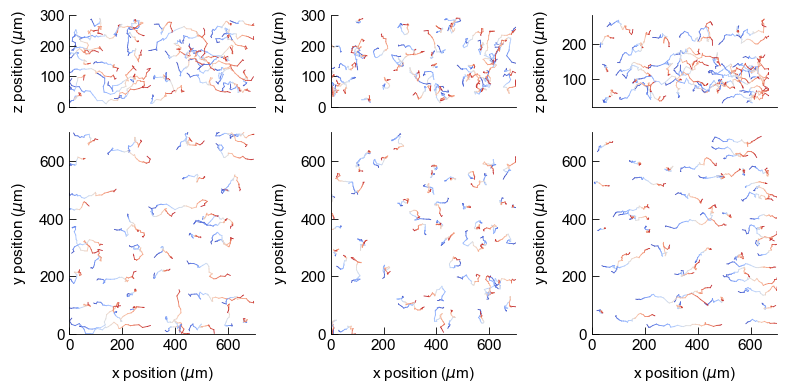

In [25]:

fig = plt.figure(figsize=(8, 4))

gs = gridspec.GridSpec(2, 3, height_ratios=[1, (1024.0 * 0.642) / 300])

###########################
###########################
# a
###########################
###########################
ax_wt_xz = plt.subplot(gs[0])
ax_wt_xy = plt.subplot(gs[3])

# Filter the DataFrame
df_temp = df[df.celltype == 'dHL60KW']
df_temp = df_temp[df_temp.date == 20240211]
df_temp = df_temp[df_temp.user == 'NB']
df_temp = df_temp[df_temp.E_V_cm == 3]
df_temp = df_temp[df_temp.trial == 1]

df_temp_ = pd.DataFrame()
for g, d_ in df_temp.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 10):
        continue
    
    df_temp_ = pd.concat([df_temp_, d_], ignore_index=True)
    
df_temp_.head()

ip = 0.642  # ip = 200.0/303.0
d = df_temp_
num_cells = len(d.cell.unique())

random_50_numbers = random.sample(d.cell.unique().tolist(), 50)

# Create a colormap
cmap = plt.get_cmap('coolwarm')  # A colormap that goes from blue to red

for c, d_ in d.groupby('cell'):
    if c not in random_50_numbers:
        continue
    
    if len(d_) <= 15:
        continue

    x = d_.x 
    y = d_.y
    z = d_.z
    time = np.arange(d_.frame.min(), d_.frame.max())
    
    # Normalize the time array to range from 0 to 1 based on a fixed range of 0 to 30 minutes
    norm_time = (time - np.min(time)) / (30.0)  # 30 minutes max

    for i in range(len(x) - 1):
        ax_wt_xz.plot(x[i:i+2], z[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax_wt_xz.set_ylim(0, 300)
    ax_wt_xz.set_xlim(0, 700)  
    ax_wt_xz.set_ylabel('z position ($\mu$m)')
    
    # Plot the trajectory on the first subplot
    for i in range(len(x) - 1):
        ax_wt_xy.plot(x[i:i+2], y[i:i+2], color=cmap(norm_time[i]), linewidth=0.6)
    ax_wt_xy.set_xlabel('x position ($\mu$m)')
    ax_wt_xy.set_ylabel('y position ($\mu$m)')
    ax_wt_xy.set_xlim(0, 700)
    ax_wt_xy.set_ylim(0, 700)  

    ax_wt_xz.xaxis.set_visible(False)

# Add a colorbar to the first subplot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=30))  # 0 to 30 minutes
sm.set_array([])

# Set the ticks and labels for the colorbar
tick_positions = np.linspace(0, 30, num=4)  # Ticks at every 10 minutes (0, 10, 20, 30)
tick_labels = np.arange(0, 31, 10)  # Labels from 0 to 30 minutes at 10-minute intervals

cbar = fig.colorbar(sm, ax=ax_wt_xy, orientation='vertical', label='Time (minutes)')
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

plt.tight_layout()

# plt.savefig('../../figures/Figure3_draft1_colormap.pdf')

# Average speed calculations

In [5]:
celllines = df.celltype.unique() 
colors = sns.color_palette("tab10")
color_dict = dict(zip(df.celltype.unique(), colors))    
color_dict.update({'dHL60KW':'#B8BABC'})

0
dHL60KW
0.08531550280951188
0.07636640185317524
0.08865657147820691
0.05592689893996767
dHL60TMEM154KO
0.07714672407331437
0.06509583070157175
0.05997728907269512
0.06299053715464098
0.056650006923257716
0.06942555155253785
0.06289349406384145
dHL60TMEM154KO-clone1galvanin-GFP-HA
0.062017746839503014
0.030024673874601154
0.04645298964799395
0.07187163486468967
0.07569439619041407
0.08759163447388049
0.07610841492562864
0.051695684277266785
0.05012211993983101
1
dHL60KW
0.07920830249735004
0.0675895348977802
0.06741273547423599
0.09304940546444582
0.058807808240727705
0.07064212348726237
dHL60TMEM154KO
0.06571700938285434
0.07207234723958475
0.08102524301546031
0.07928545358456916
0.07901660977750033
0.07186318792046964
0.08028892026468282
0.07223217550717433
dHL60TMEM154KO-clone1galvanin-GFP-HA
0.04041835176030825
0.055112294451832605
0.08388795390373849
0.07536017950371475
0.07804914287126441
0.05889808818546876
0.054971201699159165
3
dHL60KW
0.10969991390297808
0.07164881635986206


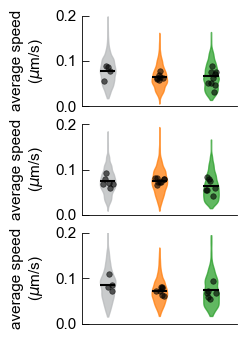

In [7]:

fig, ax = plt.subplots(3,1, figsize = (2, 4))

celltype_dict = dict(zip(df.celltype.unique(), np.arange(len(df.celltype.unique()))))
axes_dict = dict(zip([0, 1, 3], [0, 1, 2]))

vp_3d_s = np.empty_like(np.array(ax))

for E, df_ in df[df.E_V_cm != 5].groupby('E_V_cm'):
    print(E)
    for c, df_temp in df_.groupby('celltype'):
        print(c)
        ind = celltype_dict[c]
        speed_all = []
        
        for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
            speed_prep = []
            for cell, d_ in d.groupby('cell'):
                if len(d_.frame.unique()) > 16:
                    speed_cell = []
                    for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                        vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                  d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                  d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                        speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))

                speed_prep = np.append(speed_prep, np.mean(speed_cell)) 

            # Add random jitter to the x-coordinate
            jitter = np.random.uniform(-0.1, 0.1)
            x_position = celltype_dict[c] + jitter
            
            ax[axes_dict[E]].errorbar(x_position, np.mean(speed_prep),
                                      markersize=4, marker='o', color='k',
                                      markeredgecolor='k',
                                      markeredgewidth=0.5,
                                      lw=0.5,
                                      alpha=0.6, zorder=10)   

            speed_all = np.append(speed_all, speed_prep)
            print(np.mean(speed_prep))

        vp_3d_s = ax[axes_dict[E]].violinplot(speed_all, positions=[celltype_dict[c]], points=60, widths=0.3,
                                              showmeans=False, showextrema=False, showmedians=False,
                                              bw_method=0.2)
        
        
        color = color_dict[c]
        
        for pc in vp_3d_s['bodies']:
            pc.set_color(color)
            pc.set_alpha(0.75)
            pc.set_zorder(0)

        ax[axes_dict[E]].hlines(speed_all.mean(), celltype_dict[c]-0.15, celltype_dict[c]+0.15, zorder=10, lw=1.5, color='k')

        ax[axes_dict[E]].set_xlim(-0.5, 2.5)
        ax[axes_dict[E]].xaxis.set_visible(False)
        ax[axes_dict[E]].set_ylim(0, 0.2)
        ax[axes_dict[E]].set_yticks([0.0, 0.1, 0.2])
        ax[axes_dict[E]].set_ylabel('average speed\n' + r'($\mu$m/s)')

# plt.savefig('../../figures/Figure3_avg_speeds_.pdf')

In [11]:
# for g,d, in df.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user']):
    # print(g)

### perform statisics

In [7]:
celltype_dict = dict(zip(df.celltype.unique(), np.arange(len(df.celltype.unique()))))

for E, df_ in df[df.E_V_cm == 0].groupby('E_V_cm'):
    print(E)
    for c, df_temp in df_.groupby('celltype'):
        if c == 'dHL60KW':
            speed_all_kw = []
            for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
                speed_prep = []
                for cell, d_ in d.groupby('cell'):
                    if len(d_.frame.unique()) > 16:
                        speed_cell = []
                        for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                            vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                      d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                      d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                            speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))
    
                    speed_prep = np.append(speed_prep, np.mean(speed_cell)) 
                speed_all_kw = np.append(speed_all_kw, np.mean(speed_prep))
                
        if c == 'dHL60TMEM154KO':
            speed_all_ko = []
            for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
                speed_prep = []
                for cell, d_ in d.groupby('cell'):
                    if len(d_.frame.unique()) > 16:
                        speed_cell = []
                        for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                            vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                      d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                      d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                            speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))
    
                    speed_prep = np.append(speed_prep, np.mean(speed_cell)) 
                speed_all_ko = np.append(speed_all_ko, np.mean(speed_prep))
                
        if c == 'dHL60TMEM154KO-clone1galvanin-GFP-HA':
            speed_all_res = []
            for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
                speed_prep = []
                for cell, d_ in d.groupby('cell'):
                    if len(d_.frame.unique()) > 16:
                        speed_cell = []
                        for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                            vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                      d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                      d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                            speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))
    
                    speed_prep = np.append(speed_prep, np.mean(speed_cell)) 
                speed_all_res = np.append(speed_all_res, np.mean(speed_prep))
    
df_treat = speed_all_ko
df_control = speed_all_kw
print('KO_wt', scipy.stats.mannwhitneyu(df_treat, df_control))

df_treat = speed_all_res
df_control = speed_all_kw
print('res_wt', scipy.stats.mannwhitneyu(df_treat, df_control))         

0
KO_wt MannwhitneyuResult(statistic=8.0, pvalue=0.3151515151515151)
res_wt MannwhitneyuResult(statistic=7.0, pvalue=0.1062937062937063)


In [9]:
for E, df_ in df[df.E_V_cm == 1].groupby('E_V_cm'):
    print(E)
    for c, df_temp in df_.groupby('celltype'):
        if c == 'dHL60KW':
            speed_all_kw = []
            for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
                speed_prep = []
                for cell, d_ in d.groupby('cell'):
                    if len(d_.frame.unique()) > 16:
                        speed_cell = []
                        for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                            vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                      d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                      d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                            speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))
    
                    speed_prep = np.append(speed_prep, np.mean(speed_cell)) 
                speed_all_kw = np.append(speed_all_kw, np.mean(speed_prep))
                
        if c == 'dHL60TMEM154KO':
            speed_all_ko = []
            for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
                speed_prep = []
                for cell, d_ in d.groupby('cell'):
                    if len(d_.frame.unique()) > 16:
                        speed_cell = []
                        for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                            vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                      d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                      d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                            speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))
    
                    speed_prep = np.append(speed_prep, np.mean(speed_cell)) 
                speed_all_ko = np.append(speed_all_ko, np.mean(speed_prep))
                
        if c == 'dHL60TMEM154KO-clone1galvanin-GFP-HA':
            speed_all_res = []
            for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
                speed_prep = []
                for cell, d_ in d.groupby('cell'):
                    if len(d_.frame.unique()) > 16:
                        speed_cell = []
                        for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                            vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                      d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                      d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                            speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))
    
                    speed_prep = np.append(speed_prep, np.mean(speed_cell)) 
                speed_all_res = np.append(speed_all_res, np.mean(speed_prep))
    
df_treat = speed_all_ko
df_control = speed_all_kw
print('KO_wt', scipy.stats.mannwhitneyu(df_treat, df_control))

df_treat = speed_all_res
df_control = speed_all_kw
print('res_wt', scipy.stats.mannwhitneyu(df_treat, df_control))      

1
KO_wt MannwhitneyuResult(statistic=32.0, pvalue=0.344988344988345)
res_wt MannwhitneyuResult(statistic=14.0, pvalue=0.36596736596736595)


In [8]:
for E, df_ in df[df.E_V_cm == 3].groupby('E_V_cm'):
    print(E)
    for c, df_temp in df_.groupby('celltype'):
        if c == 'dHL60KW':
            speed_all_kw = []
            for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
                speed_prep = []
                for cell, d_ in d.groupby('cell'):
                    if len(d_.frame.unique()) > 16:
                        speed_cell = []
                        for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                            vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                      d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                      d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                            speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))
    
                    speed_prep = np.append(speed_prep, np.mean(speed_cell)) 
                speed_all_kw = np.append(speed_all_kw, np.mean(speed_prep))
                
        if c == 'dHL60TMEM154KO':
            speed_all_ko = []
            for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
                speed_prep = []
                for cell, d_ in d.groupby('cell'):
                    if len(d_.frame.unique()) > 16:
                        speed_cell = []
                        for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                            vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                      d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                      d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                            speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))
    
                    speed_prep = np.append(speed_prep, np.mean(speed_cell)) 
                speed_all_ko = np.append(speed_all_ko, np.mean(speed_prep))
                
        if c == 'dHL60TMEM154KO-clone1galvanin-GFP-HA':
            speed_all_res = []
            for g, d in df_temp.groupby(['date', 'trial', 'user'], sort=False):
                speed_prep = []
                for cell, d_ in d.groupby('cell'):
                    if len(d_.frame.unique()) > 16:
                        speed_cell = []
                        for t in np.arange(d_.frame.min(), d_.frame.max(), 3)[1:]:
                            vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                                      d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0],
                                      d_[d_.frame == t].z.values[0] - d_[d_.frame == t-3].z.values[0]]
                            speed_cell = np.append(speed_cell, np.sqrt(vec_t1[0]**2 + vec_t1[1]**2 + vec_t1[2]**2) / (3*60))
    
                    speed_prep = np.append(speed_prep, np.mean(speed_cell)) 
                speed_all_res = np.append(speed_all_res, np.mean(speed_prep))
    
df_treat = speed_all_ko
df_control = speed_all_kw
print('KO_wt', scipy.stats.mannwhitneyu(df_treat, df_control))

df_treat = speed_all_res
df_control = speed_all_kw
print('res_wt', scipy.stats.mannwhitneyu(df_treat, df_control))     

3
KO_wt MannwhitneyuResult(statistic=4.0, pvalue=0.07272727272727272)
res_wt MannwhitneyuResult(statistic=4.0, pvalue=0.11428571428571428)
